In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
import cv2
from PIL import Image
import os

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.metrics import MeanIoU, Accuracy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from keras import backend as K
def adjustData(img, mask):
  onehot=mask/255                 ###pixel normalization
  return(img, onehot)

def TrainGenerator(aug_dict, image_folder, mask_folder, batch_size, save_to_dir, seed = 1, image1_save_prefix = "image",  mask_save_prefix = "mask"):
  image_datagen = ImageDataGenerator(**aug_dict)
  mask_datagen = ImageDataGenerator(**aug_dict)

  image_generator = image_datagen.flow_from_directory(
       directory = image_folder,
       target_size = (512, 512),
       color_mode = 'rgb',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = image1_save_prefix,
       shuffle = True,
       seed = seed
  )
  mask_generator = mask_datagen.flow_from_directory(
      directory = mask_folder,
      target_size = (512, 512),
       color_mode = 'grayscale',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = mask_save_prefix,
       shuffle = True,
       seed = seed
  )
  train_generator = zip(image_generator, mask_generator)
  for (img, mask) in train_generator:
        X=[]
        Y=[]
        for d in range(img.shape[0]):
            x, y = adjustData(img[d], mask[d])
            X.append(x)
            Y.append(y)
        X = np.reshape(np.array(X),(img.shape[0],512, 512,3))
        Y = np.reshape(np.array(Y),(img.shape[0],512, 512,1))
        yield X, Y

def ValGenerator(aug_dict, image_folder, mask_folder, batch_size, save_to_dir, seed = 1, image_save_prefix = "image", mask_save_prefix = "mask"):
  image_datagen = ImageDataGenerator(**aug_dict)
  mask_datagen = ImageDataGenerator(**aug_dict)

  image_generator = image_datagen.flow_from_directory(
       directory = image_folder,
       target_size = (512, 512),
       color_mode = 'rgb',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = image_save_prefix,
       shuffle = True,
       seed = seed
  )
  mask_generator = mask_datagen.flow_from_directory(
      directory = mask_folder,
      target_size = (512, 512),
       color_mode = 'grayscale',
       class_mode = None,
       batch_size = batch_size,
       save_to_dir = save_to_dir,
       save_prefix = mask_save_prefix,
       shuffle = True,
       seed = seed
  )

  valid_generator = zip(image_generator, mask_generator)
  for (img, mask) in valid_generator:
        X=[]
        Y=[]
        for d in range(img.shape[0]):
            x, y = adjustData(img[d], mask[d])
            X.append(x)
            Y.append(y)
        X = np.reshape(np.array(X),(img.shape[0],512, 512,3))
        Y = np.reshape(np.array(Y),(img.shape[0],512, 512,1))
        yield X, Y

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_gen_args = dict()
Generator = TrainGenerator(aug_dict=data_gen_args,image_folder='/content/drive/Shareddrives/Untitled shared drive/Nitk Final Project/Train/I/',
                           mask_folder='/content/drive/Shareddrives/Untitled shared drive/Nitk Final Project/Train/G',batch_size=4,save_to_dir=None)
Val = ValGenerator(aug_dict=data_gen_args,image_folder='/content/drive/Shareddrives/Untitled shared drive/Nitk Final Project/Val/I',
                   mask_folder='/content/drive/Shareddrives/Untitled shared drive/Nitk Final Project/Val/G',batch_size=4,save_to_dir=None)



In [5]:
from tensorflow.keras.layers import (Input, Conv2D, Conv2DTranspose, MaxPooling2D,
                                     Dropout, concatenate, Add, Activation)
from tensorflow.keras.models import Model

def residual_block(x, filters, kernel_size=3, dropout=0.0):
    """
    A simple residual block:
      1) Convolution -> ReLU
      2) (Optional) Dropout
      3) Convolution
      4) Add the original 'x' (possibly projected to 'filters') to the output
      5) ReLU
    """
    shortcut = x  # Keep track of input for skip connection

    # First convolution
    x = Conv2D(filters, (kernel_size, kernel_size), padding='same',
               kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)

    # Optional dropout in the middle (if needed)
    if dropout > 0.0:
        x = Dropout(dropout)(x)

    # Second convolution
    x = Conv2D(filters, (kernel_size, kernel_size), padding='same',
               kernel_initializer='he_normal')(x)

    # If number of filters doesn't match, use 1x1 conv to match them
    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = Conv2D(filters, kernel_size=(1,1),
                          padding='same',
                          kernel_initializer='he_normal')(shortcut)

    # Residual addition
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

In [6]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

c1 = residual_block(inputs, 16, dropout=0.0)
p1 = MaxPooling2D((2, 2))(c1)

    # Block 2
c2 = residual_block(p1, 32, dropout=0.0)
p2 = MaxPooling2D((2, 2))(c2)

    # Block 3
c3 = residual_block(p2, 64, dropout=0.0)
p3 = MaxPooling2D((2, 2))(c3)

    # Block 4 (add dropout if you like)
c4 = residual_block(p3, 128, dropout=0.2)
p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
c5 = residual_block(p4, 256, dropout=0.4)

    # ---- Decoder ----
    # Up block 6
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = residual_block(u6, 128, dropout=0.2)

    # Up block 7
u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = residual_block(u7, 64, dropout=0.0)

    # Up block 8
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = residual_block(u8, 32, dropout=0.0)

    # Up block 9
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1])
c9 = residual_block(u9, 16, dropout=0.0)

    # Output
outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
model = Model(inputs=[inputs], outputs=[outputs])

In [7]:
# define loss function
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 512, 512, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 16)   │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 512, 512, 16)   │             64 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 512, 512, 16)   │              0 │ conv2d_1[0][0],        │
│                           │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 512, 512, 16)   │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 16)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 256, 256, 32)   │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 256, 256, 32)   │            544 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 256, 256, 32)   │              0 │ conv2d_4[0][0],        │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 256, 256, 32)   │              0 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 32)   │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 128, 128, 64)   │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)    

 Total params: 2,028,929 (7.74 MB)

 Trainable params: 2,028,929 (7.74 MB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',mode='min',factor=0.5,patience=10,verbose=1,cooldown=1,min_delta=0.0001)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=20,verbose=1,mode='min',restore_best_weights=True)


In [9]:
check_path = '/content/drive/MyDrive/FDP_Lab/MultiSeg_Python/DL_Building/RESDUNet_Building.weights.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(check_path,monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=True,mode='min')

history = model.fit(Generator,validation_data =Val, validation_steps= 9,steps_per_epoch=308,shuffle=True,verbose=1,epochs=10,callbacks=[reduce_lr,early_stop,checkpoint])

Found 1233 images belonging to 1 classes.
Found 1233 images belonging to 1 classes.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 512, 512, 3))
  warnings.warn(msg)


308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5642 - loss: 39.9153Found 36 images belonging to 1 classes.
Found 36 images belonging to 1 classes.

Epoch 1: val_loss improved from inf to 1.87321, saving model to /content/drive/MyDrive/FDP_Lab/MultiSeg_Python/DL_Building/RESDUNet_Building.weights.h5
308/308 ━━━━━━━━━━━━━━━━━━━━ 957s 3s/step - accuracy: 0.5646 - loss: 39.8273 - val_accuracy: 0.8211 - val_loss: 1.8732 - learning_rate: 1.0000e-04
Epoch 2/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8107 - loss: 1.9789
Epoch 2: val_loss improved from 1.87321 to 1.24606, saving model to /content/drive/MyDrive/FDP_Lab/MultiSeg_Python/DL_Building/RESDUNet_Building.weights.h5
308/308 ━━━━━━━━━━━━━━━━━━━━ 64s 160ms/step - accuracy: 0.8108 - loss: 1.9780 - val_accuracy: 0.8293 - val_loss: 1.2461 - learning_rate: 1.0000e-04
Epoch 3/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8401 - loss: 1.2344
Epoch 3: val_loss improved from 1.24606 to 0.86924, saving model t

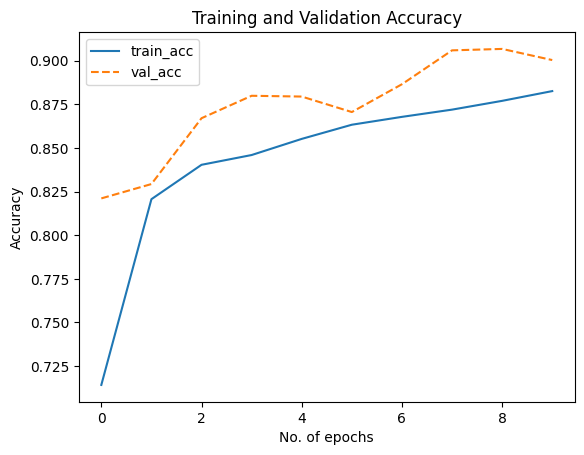

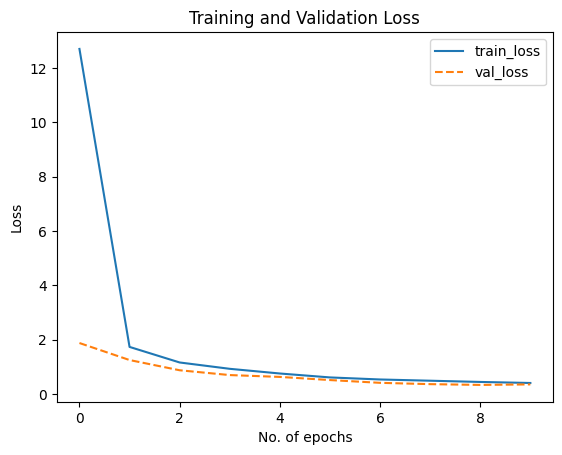

In [10]:
plt.plot(history.history['accuracy'] , label = 'train_acc')
plt.plot(history.history['val_accuracy'] ,'--', label = 'val_acc')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.show()

plt.plot(history.history['loss'] , label = 'train_loss')
plt.plot(history.history['val_loss'] ,'--', label = 'val_loss')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

In [11]:
model.load_weights('/content/drive/MyDrive/FDP_Lab/MultiSeg_Python/DL_Building/RESDUNet_Building.weights.h5')
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 512, 512, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 16)   │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 512, 512, 16)   │             64 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 512, 512, 16)   │              0 │ conv2d_1[0][0],        │
│                           │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 512, 512, 16)   │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 16)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 256, 256, 32)   │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 256, 256, 32)   │            544 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 256, 256, 32)   │              0 │ conv2d_4[0][0],        │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 256, 256, 32)   │              0 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 32)   │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 128, 128, 64)   │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)    

 Total params: 6,086,789 (23.22 MB)

 Trainable params: 2,028,929 (7.74 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,057,860 (15.48 MB)

None


In [12]:
import os
gtappend = []
predappend =[]
imgs = []
addA = "/content/drive/Shareddrives/Untitled shared drive/Nitk Final Project/Test/I/x/" # Added trailing slash
addlabel = "/content/drive/Shareddrives/Untitled shared drive/Nitk Final Project/Test/G/y/" # Added trailing slash

for eg in os.listdir(addA):
    imageA = os.path.join(addA, eg)  # Use os.path.join to create correct path
    GT = os.path.join(addlabel, eg) # Use os.path.join to create correct path
    x1 = (plt.imread(imageA))*255
    x2 = (plt.imread(GT))
    a = np.reshape(x1,(1,512,512,3))
    c = x2[:,:,0]
    y = model.predict(a)
    y = np.reshape(y,(512,512))
    result = np.where(y>0.5,1,0)
    predappend.append(result)
    gtappend.append(c)
    imgs.append(x1)

g = np.stack(gtappend, axis=0)
p = np.stack(predappend, axis=0)
imgs = np.array(imgs)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 512, 512, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━

Text(0.5, 1.0, 'Predicted image')

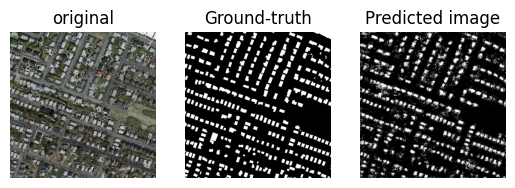

In [13]:
fig=plt.figure()
fig.figsize=(30,30)

ax=fig.add_subplot(1,3,1)
ax.imshow((imgs[2]/255))
plt.axis('off')
plt.title("original")

ax=fig.add_subplot(1,3,2)
ax.imshow(np.reshape(g[2],(512,512)),cmap="gray")
plt.axis('off')
plt.title("Ground-truth")

ax=fig.add_subplot(1,3,3)
ax.imshow(np.reshape(p[2],(512,512)),cmap="gray")
plt.axis('off')
plt.title("Predicted image")

Text(0.5, 1.0, 'Predicted image')

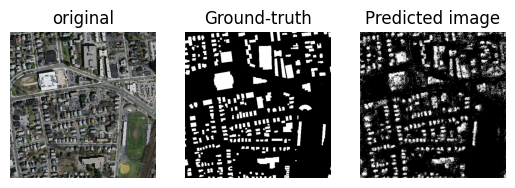

In [14]:
fig=plt.figure()
fig.figsize=(30,30)

ax=fig.add_subplot(1,3,1)
ax.imshow((imgs[19]/255))
plt.axis('off')
plt.title("original")

ax=fig.add_subplot(1,3,2)
ax.imshow(np.reshape(g[19],(512,512)),cmap="gray")
plt.axis('off')
plt.title("Ground-truth")

ax=fig.add_subplot(1,3,3)
ax.imshow(np.reshape(p[19],(512,512)),cmap="gray")
plt.axis('off')
plt.title("Predicted image")

In [15]:
from sklearn.metrics import *
gt=(g.ravel()).astype('int')
pd=(p.ravel()).astype('int')
f1 = f1_score(gt,pd,average='macro')
kappa = cohen_kappa_score(gt,pd)
accuracy = accuracy_score(gt,pd)
jaccard = jaccard_score(gt,pd,average='macro')
precision = precision_score(gt,pd,average='macro')
recall = recall_score(gt,pd,average='macro')
print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

### Dice Coefficient
def get_dice(y_true, y_pred):
    intersection = np.sum(y_true * y_pred, axis=(0, 1, 2))
    union = np.sum(y_true**2, axis=(0, 1, 2)) + np.sum(y_pred**2, axis=(0, 1, 2))
    dc = 2 * intersection / union
    return dc

dice_coeff = get_dice(g, p)
print("dc = ",np.mean(dice_coeff))

[0 1] [0 1]
F1 SCORE: 0.6999258417538913
Kappa: 0.4053481405187619
Accuracy: 0.8455854627821181
Jaccard Score: 0.5792124995680872
Precision: 0.7544107112438216
Recall: 0.6737119838369767
dc =  0.49085961260510613


In [ ]:
import random
import cv2
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from skimage import measure
from skimage import filters

def Opening(image, filter_size):
    #Opening is just another name of erosion followed by dilation
    img=np.copy(image)
    kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(filter_size,filter_size))
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return opening

def Closing(image,k):# closing is useful to detect the overall contour of a figure and opening is suitable to detect subpatterns.
    kernel = np.ones((k, k), np.uint8)
    img=np.copy(image)
    img_close = cv2.morphologyEx(img, op= cv2.MORPH_CLOSE,kernel=kernel)
    return img_close

def Denoise(image,k):
    img=np.copy(image)
    struct=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(k,k))
    img=cv2.morphologyEx(img,cv2.MORPH_OPEN,struct)
    return img

def Binary(image, threshold, max_value = 1):
    img=np.copy(image)
    (t,masklayer)=cv2.threshold(img,threshold,max_value,cv2.THRESH_BINARY)
    return masklayer

def Gaussian_filter(image, sigma =1):
    img=np.copy(image)
    blur = filters.gaussian(img, sigma=sigma)
    return blur

def Find_threshold_otsu(image):
    t = filters.threshold_otsu(image)
    return t

def ExtractObjects(image):
    img=np.copy(image)
    blob_labels=measure.label(img,background=0)
    number_of_objects=np.unique(blob_labels)
    return blob_labels,number_of_objects

def post_processing(img):

    blur = Gaussian_filter(img, sigma=1)
    t = Find_threshold_otsu(blur)
    binary_img = Binary(blur,t)
    opened_img  = Opening(binary_img, filter_size = 3)
    blob_labels,number_of_objects = ExtractObjects(opened_img)

    return opened_img, number_of_objects, blob_labels

In [ ]:
number = 0 #56 ,34
pred = p[number,:,:]

opened_img, number_of_objects, blob_labels = post_processing(pred)
print("Number of Buildings in prediction: {}".format(number_of_objects[-1]))

gt = g[number,:,:]
opened_img1, number_of_objects1, blob_labels1 = post_processing(gt)
print("Number of Buildings in Groundtruth: {}".format(number_of_objects1[-1]))

f, axs = plt.subplots(1,5, figsize=(23,23))
img = imgs[number,:,:,:]/255
img = np.reshape(img,(img.shape[0],img.shape[1],3))
# img = img.astype('uint8')
axs[0].imshow(img)
axs[0].set_title("Original")

gt = g[number,:,:]
gt = np.reshape(gt,(gt.shape[0],gt.shape[1]))
axs[1].imshow(gt)
axs[1].set_title("Ground Truth")

axs[2].imshow(opened_img)
axs[2].set_title("Prediction")


axs[3].imshow(blob_labels, cmap='gist_ncar')
axs[3].set_title("Number of buildings: {}".format(number_of_objects[-1]))

axs[4].imshow(blob_labels1, cmap='gist_ncar')
axs[4].set_title("Number of buildings in gt: {}".format(number_of_objects1[-1]))

f.show()

In [ ]:
number = 10 #56 ,34
pred = p[number,:,:]

opened_img, number_of_objects, blob_labels = post_processing(pred)
print("Number of Buildings in prediction: {}".format(number_of_objects[-1]))

gt = g[number,:,:]
opened_img1, number_of_objects1, blob_labels1 = post_processing(gt)
print("Number of Buildings in Groundtruth: {}".format(number_of_objects1[-1]))

f, axs = plt.subplots(1,5, figsize=(23,23))
img = imgs[number,:,:,:]/255
img = np.reshape(img,(img.shape[0],img.shape[1],3))
# img = img.astype('uint8')
axs[0].imshow(img)
axs[0].set_title("Original")

gt = g[number,:,:]
gt = np.reshape(gt,(gt.shape[0],gt.shape[1]))
axs[1].imshow(gt)
axs[1].set_title("Ground Truth")

axs[2].imshow(opened_img)
axs[2].set_title("Prediction")


axs[3].imshow(blob_labels, cmap='gist_ncar')
axs[3].set_title("Number of buildings: {}".format(number_of_objects[-1]))

axs[4].imshow(blob_labels1, cmap='gist_ncar')
axs[4].set_title("Number of buildings in gt: {}".format(number_of_objects1[-1]))

f.show()

In [ ]:
for i in range(10,20):
    number = i
    img = p[number,:,:]

    opened_img, number_of_objects, blob_labels = post_processing(img)
    gt = g[number,:,:]
    opened_img1, number_of_objects1, blob_labels1 = post_processing(gt)

    f, axs = plt.subplots(1,5, figsize=(23,23))
    img = imgs[number,:,:,:]/255
    img = np.reshape(img,(img.shape[0],img.shape[1],3))
    # img = img.astype('uint8')
    axs[0].imshow(img)
    axs[0].set_title("Original")

    gt = g[number,:,:]
    gt = np.reshape(gt,(gt.shape[0],gt.shape[1]))
    axs[1].imshow(gt)
    axs[1].set_title("Ground Truth")

    axs[2].imshow(opened_img)
    axs[2].set_title("Prediction")

    axs[3].imshow(blob_labels, cmap='gist_ncar')
    axs[3].set_title("Number of buildings in prediction: {}".format(number_of_objects[-1]))

    axs[4].imshow(blob_labels1, cmap='gist_ncar')
    axs[4].set_title("Number of buildings in gt: {}".format(number_of_objects1[-1]))

    f.show()

In [18]:
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/NITK project final .ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/NITK project final .ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 6 image(s).
[NbConvertApp] Writing 2111571 bytes to /content/drive/MyDrive/Colab Notebooks/NITK project final .html


In [19]:
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/NITK project 2  residual U net.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/NITK project 2  residual U net.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 953368 bytes to /content/drive/MyDrive/Colab Notebooks/NITK project 2  residual U net.html
